In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
#constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS   = 3
EPOCHS = 100
FILE_PATH  = "zuno copy for resizinf"

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=FILE_PATH,
            shuffle=True,
            image_size=(IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE,
)

Found 1432 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names
class_names

['DOWNY_MILDEW_LEAF', 'FRESH_LEAF', 'LEAFMINNER_LEAF', 'POWDER_MILDEW_LEAF']

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 3 3 1 0 2 3 0 1 3 0 2 1 2 0 1 2 0 1 1 1 2 1 2 3 2 3 1 1 3]


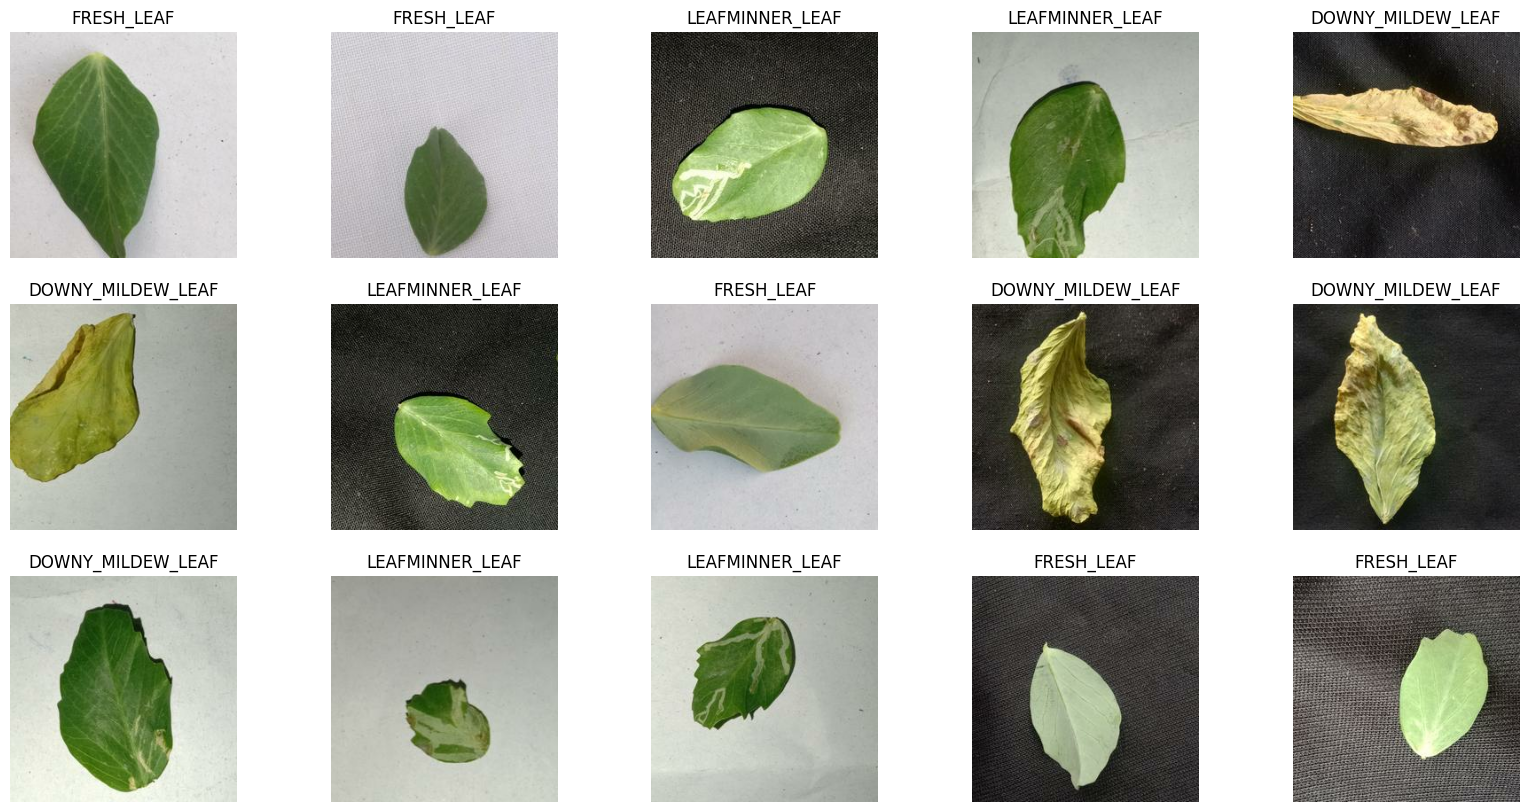

In [ ]:
plt.figure(figsize=(20,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,valid_split=0.1,shuffle=True,shuffle_size=10000):
    assert  train_split+test_split+valid_split==1
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size = int(len(ds)*train_split)
    valid_size = int(len(ds)*valid_split)


    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)

    return train_ds ,test_ds, valid_ds

In [ ]:
train_ds ,test_ds, valid_ds = get_dataset_partitions(dataset)

In [ ]:
# performance improving by both using CPU and GPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#Image Preprocessing : Rescaling and Resizing
rescale_and_resize=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,# will resize to the IMAGE_SIZE if there's any issue
    layers.experimental.preprocessing.Rescaling(1./255)  # Normalization
])

In [ ]:
#data augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)


model = models.Sequential([
    rescale_and_resize,
    data_augmentation,

    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=valid_ds,
        verbose=1,
        epochs=EPOCHS
    )

Epoch 1/50
36/36 [==============================] - 114s 3s/step - loss: 1.2986 - accuracy: 0.3568 - val_loss: 1.2381 - val_accuracy: 0.4453
Epoch 2/50
36/36 [==============================] - 104s 3s/step - loss: 1.0857 - accuracy: 0.4809 - val_loss: 0.9995 - val_accuracy: 0.5547
Epoch 3/50
36/36 [==============================] - 105s 3s/step - loss: 1.0489 - accuracy: 0.5243 - val_loss: 0.9015 - val_accuracy: 0.5859
Epoch 4/50
36/36 [==============================] - 103s 3s/step - loss: 0.9483 - accuracy: 0.5651 - val_loss: 0.9126 - val_accuracy: 0.5859
Epoch 5/50
36/36 [==============================] - 104s 3s/step - loss: 0.8562 - accuracy: 0.6337 - val_loss: 0.8827 - val_accuracy: 0.6328
Epoch 6/50
36/36 [==============================] - 103s 3s/step - loss: 0.7651 - accuracy: 0.6727 - val_loss: 0.8419 - val_accuracy: 0.6172
Epoch 7/50
36/36 [==============================] - 103s 3s/step - loss: 0.7101 - accuracy: 0.7101 - val_loss: 0.5746 - val_accuracy: 0.7500
Epoch 8/50
36

In [ ]:
scores = model.evaluate(test_ds)
scores

5/5 [==============================] - 8s 1s/step - loss: 0.1283 - accuracy: 0.9671


[0.12833267450332642, 0.9671052694320679]

In [ ]:
scores

[0.12833267450332642, 0.9671052694320679]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 36}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.3567708432674408,
 0.4809027910232544,
 0.5243055820465088,
 0.5651041865348816,
 0.6336805820465088,
 0.6727430820465088,
 0.7100694179534912,
 0.7404513955116272,
 0.7821180820465088,
 0.7795138955116272,
 0.7786458134651184,
 0.8055555820465088,
 0.7899305820465088,
 0.7986111044883728,
 0.8072916865348816,
 0.8194444179534912,
 0.8116319179534912,
 0.8116319179534912,
 0.8038194179534912,
 0.8090277910232544,
 0.8376736044883728,
 0.8506944179534912,
 0.8446180820465088,
 0.8689236044883728,
 0.8498263955116272,
 0.8715277910232544,
 0.8680555820465088,
 0.8854166865348816,
 0.8515625,
 0.8697916865348816,
 0.8836805820465088,
 0.8819444179534912,
 0.8828125,
 0.8984375,
 0.9131944179534912,
 0.9114583134651184,
 0.9166666865348816,
 0.9192708134651184,
 0.9088541865348816,
 0.921875,
 0.9201388955116272,
 0.8975694179534912,
 0.9340277910232544,
 0.9453125,
 0.9140625,
 0.9296875,
 0.9192708134651184,
 0.9279513955116272,
 0.9157986044883728,
 0.9314236044883728]

In [ ]:
len(history.history['accuracy'])

50

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

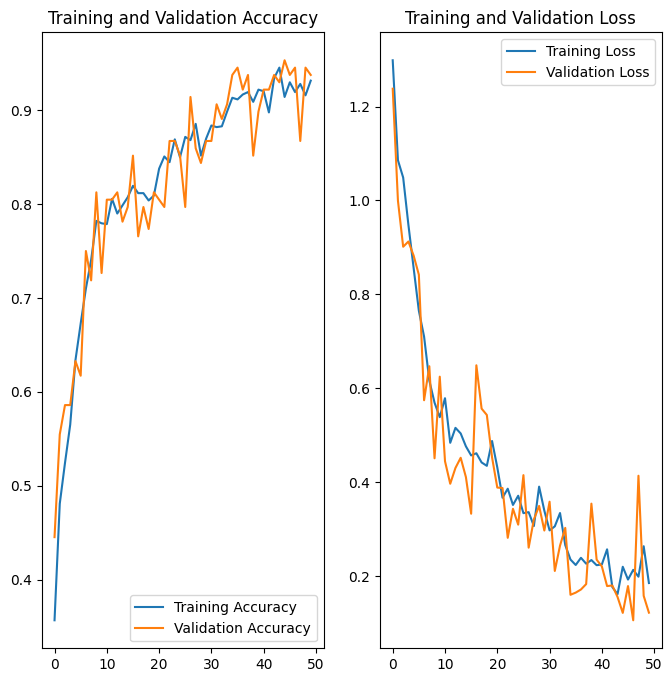

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: POWDER_MILDEW_LEAF
1/1 [==============================] - 1s 1s/step
predicted label: POWDER_MILDEW_LEAF


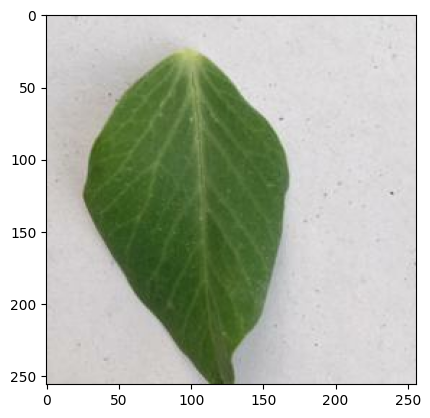

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict_tomato_diseases(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)


    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 70ms/step


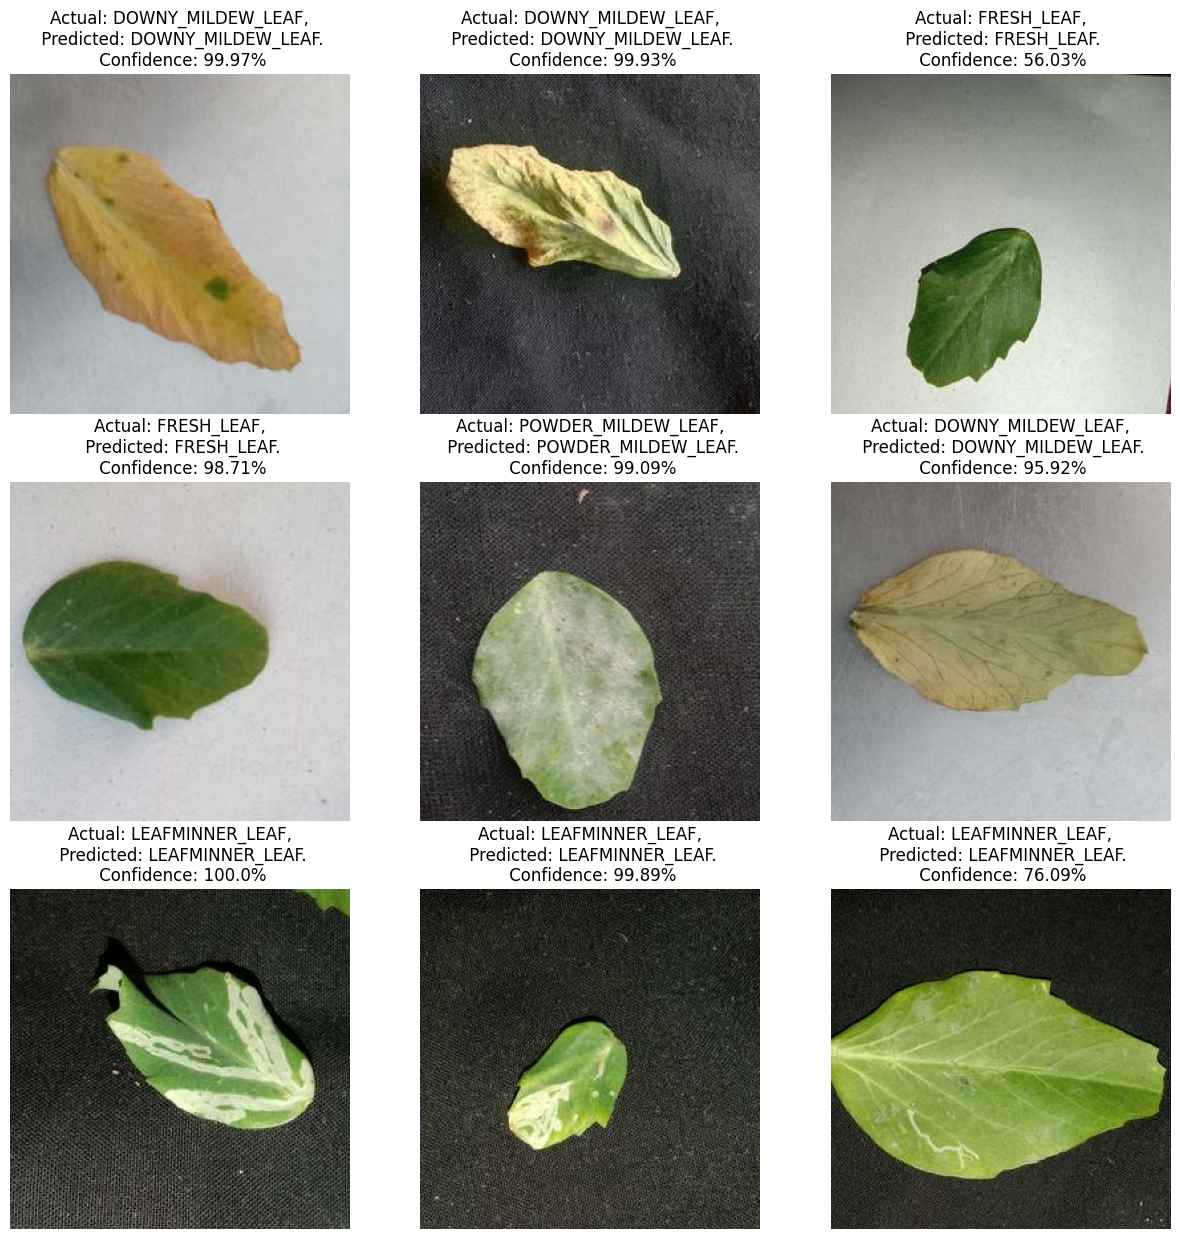

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict_tomato_diseases(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets
